Importing libraries

In [460]:
import pandas as pd
import numpy as np
from scipy.io import mmread
from scipy import stats
from scipy import sparse
import anndata as ad
import scanpy as sc
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.signal import find_peaks
import statsmodels.api as sm
import scrublet as scr
import warnings
from scipy import interpolate
import seaborn as sns

<H1>Loading Data</H1>

Getting the cleaned and feature selected python annotated object

In [81]:
ann_object_cleaned_feature_selected = sc.read(filename='dades/48h/ann_object_cleaned_feature_selected.h5ad')
ann_object_cleaned_feature_selected

AnnData object with n_obs × n_vars = 4843 × 1000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mithocondrial', 'log1p_total_counts_mithocondrial', 'pct_counts_mithocondrial', 'n_counts', 'n_genes', 'doublet_score', 'predicted_doublet', 'total_counts_normalized', 'total_counts_normalized_log'
    var: 'mithocondrial', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'neighbors', 'pca', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'gene_cientific_name'
    obsp: 'connectivities', 'distances'

<H2> Marker Genes List </H2>

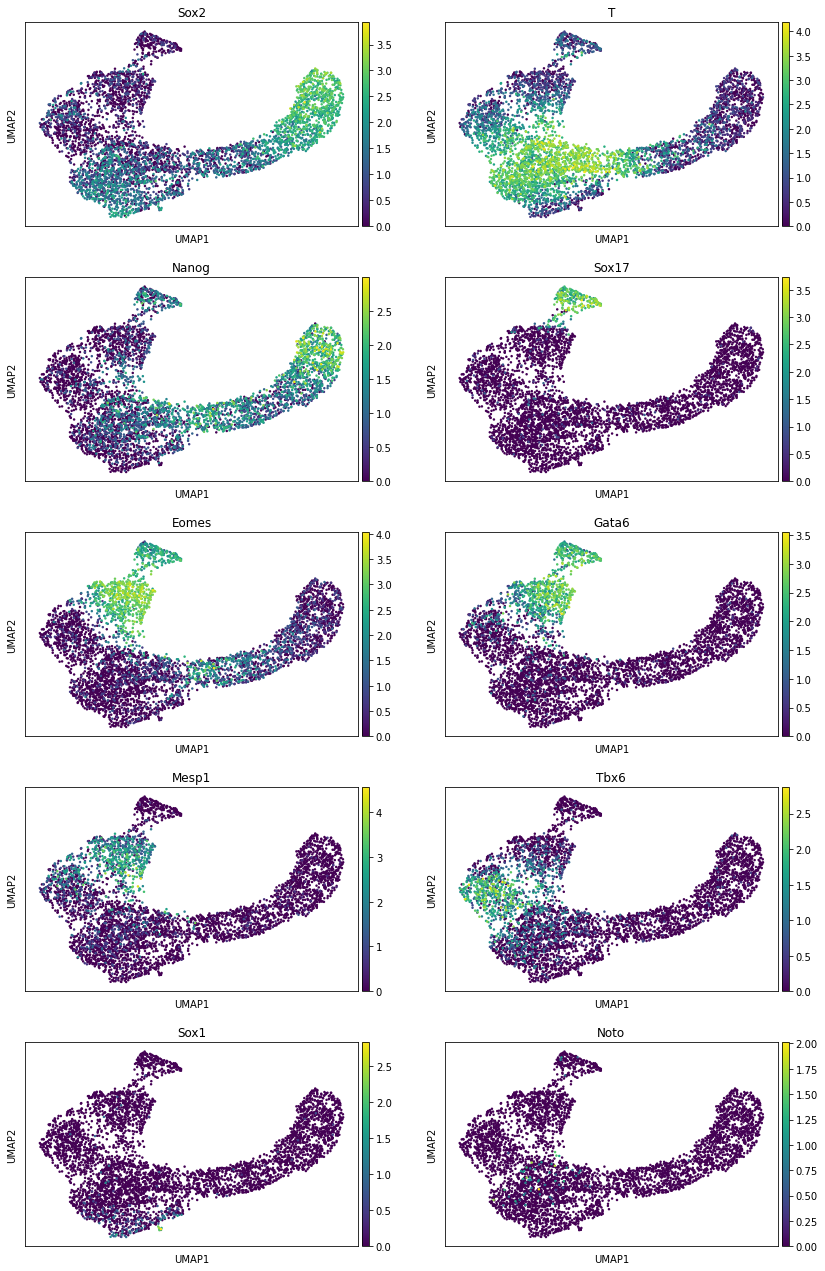

In [82]:
gene_list = ['Sox2','T','Nanog','Sox17', 'Eomes', 'Gata6', 'Mesp1', 'Tbx6', 'Sox1', 'Noto']
sc.pl.umap(ann_object_cleaned_feature_selected, color=gene_list, use_raw=False, ncols=2)

<H2> Smoothed Marker Genes </H2>

Realizamos un smoothing de los marker genes ya que unitariamente pueden marcar regiones muy claras pero también pueden contener regiones mucho más diversas, lo que produce una decisión mucho más estocástica y la prior information no está tan suvizada.

In [84]:
from sklearn.neighbors import KNeighborsRegressor

# Create a copy to avoid modifying the original data
y0 = marker_genes_mtx
for i in range(10):
    y = KNeighborsRegressor().fit(np.array(ann_object_agg.obsm['X_pca']), y0).predict(np.array(ann_object_agg.obsm['X_pca']))
    # Impute values of the KNN regressor
    y0 = y
# Scale the variance of the KNN regression result
smoothed_marker_genes_mtx = scale(y0)

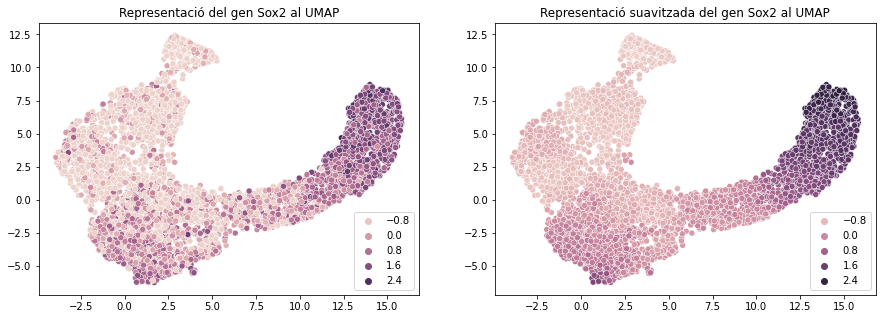

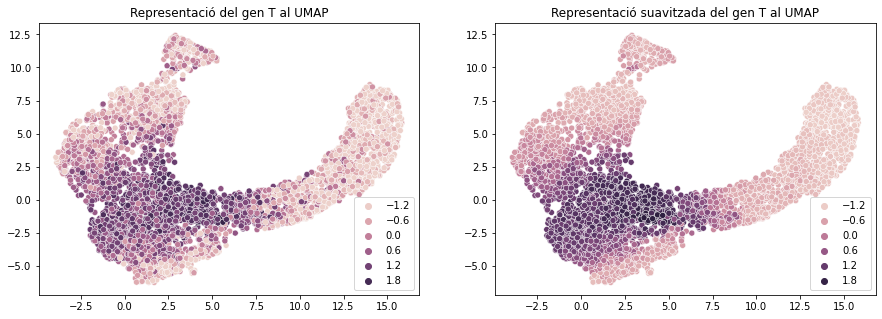

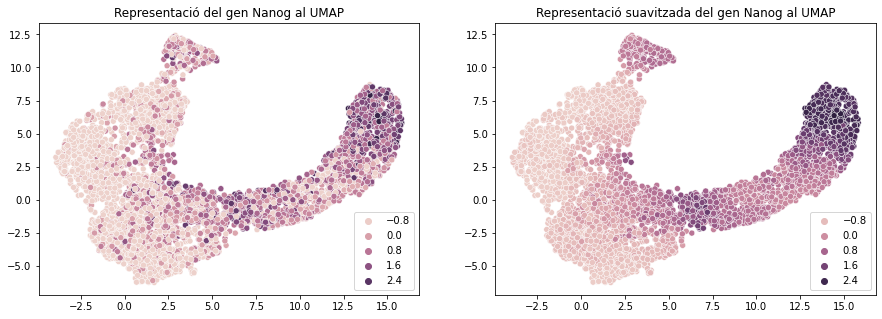

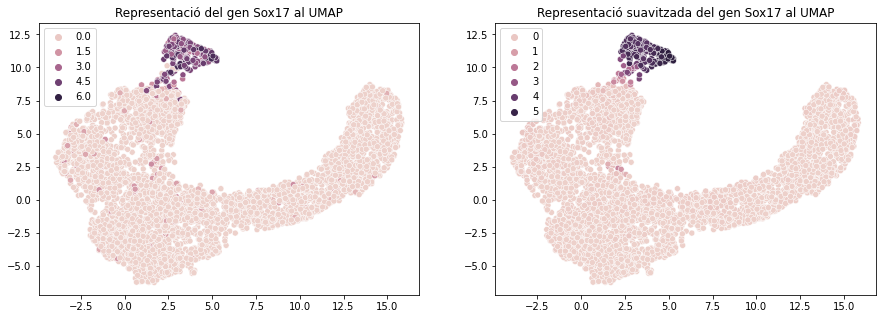

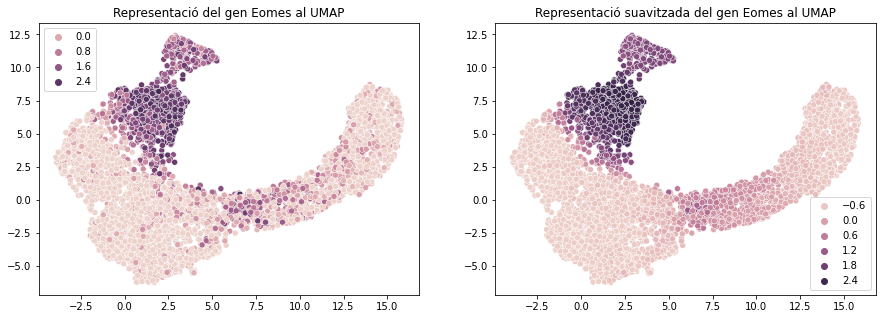

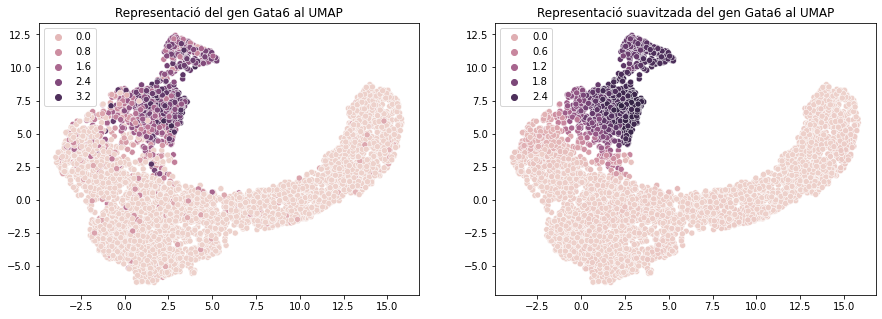

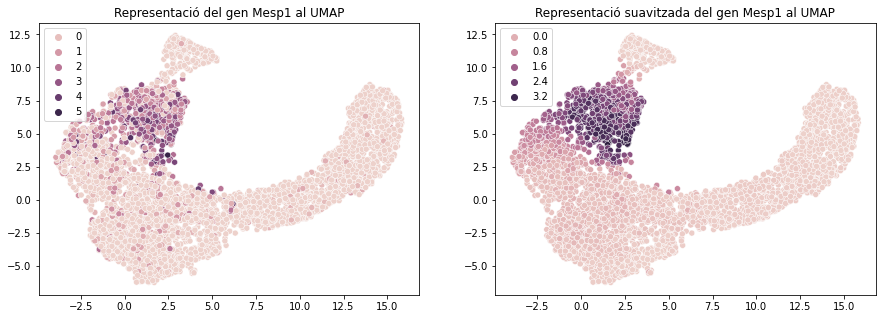

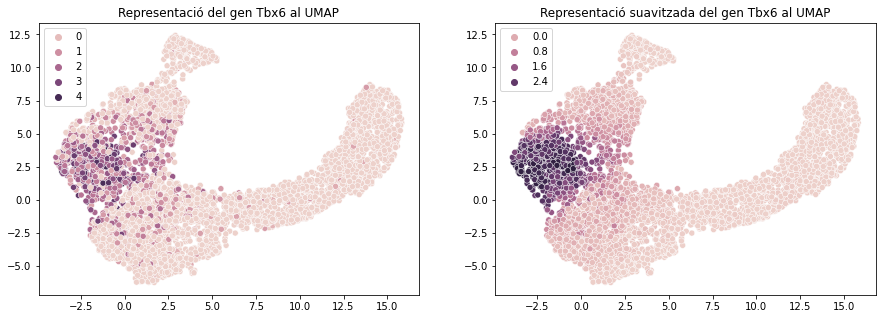

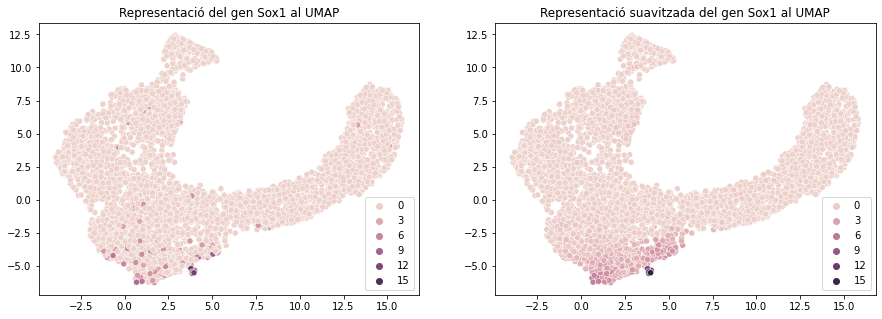

In [85]:
for col in range(y0.shape[1]):
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    #plt.title(gene_list[col])
    sns.scatterplot(x=ann_object_agg.obsm['X_umap'][:,0], y=ann_object_agg.obsm['X_umap'][:,1], hue=marker_genes_mtx[:,col], ax=axs[0])
    axs[0].set_title(f"Representació del gen {gene_list[col]} al UMAP")
    sns.scatterplot(x=ann_object_agg.obsm['X_umap'][:,0], y=ann_object_agg.obsm['X_umap'][:,1], hue=smoothed_marker_genes_mtx[:,col], ax=axs[1])
    axs[1].set_title(f"Representació suavitzada del gen {gene_list[col]} al UMAP")
    plt.show()

<H1> Function for robustness scores </H1>

In [437]:
from scipy import optimize
from sklearn import metrics
warnings.filterwarnings("ignore")

def df_squareform(df):
    """
    Transforms a DataFrame into a square matrix by adding missing rows and columns.
    Args:
        df: Input DataFrame.
    Returns:
        pd.DataFrame: Square DataFrame with missing rows and columns filled with zeros.
    """
    #Define the rows and columns of the square matrix with the values of the dataframe and adding as rows or columns that are needed to raise the max shape.
    new_index = list(df.index) + [str(i) for i in range(df.shape[0], max(df.shape))]
    new_columns = list(df.columns) + [str(i) for i in range(df.shape[1], max(df.shape))]
    # Create a new DataFrame with the rows and columns created, adding zeros on the empty rows or columns
    df_sq = df.reindex(index=new_index, columns=new_columns, fill_value=0.0)
    return df_sq

def score_intersect_clusters(df, cols_order, rows_order):
    """
    Calculates intersection scores between clusters based on a DataFrame.
    Args:
      df (pd.DataFrame): Input DataFrame.
      cols_order (list): List of column indices in the desired order.
      rows_order (list): List of row indices in the desired order.
    Returns:
      list: List of intersection scores.
    """
    intersec_list = []
    for i in range(df.shape[0]):
        #Extract the value located at the intersection of a particular row and column in the DataFrame
        val = df.loc[df.index[rows_order[i]]][df.columns[cols_order[i]]]
        #Intersection score: (The intersection value * 2) / (sum of columns + sum of rows). The score will be between 0 and 1, where 0 indicates no overlap and 1 indicates complete overlap.
        intersec = val*2 / (df.loc[:][df.columns[cols_order[i]]].sum() + df.loc[df.index[rows_order[i]]].sum())
        #Creates a list of intersection scores.
        intersec_list.append(0 if intersec == np.inf else intersec)
    return intersec_list

def mapping_funct(i, mapping):
    if i in mapping:
        return mapping[i]
    else:
        return i


# MAIN FUNCTION FOR PAIRWISE SCORES AND CLUSTER SPECIFIC SCORES
def get_robustnessscore_ofpairwisemethod(combinations_list, df, leiden=False): #old get_cluster_scores_by_metric
    """
    Calculates various cluster evaluation metrics for a given DataFrame and combinations.
    Args:
        combinations_list (list): List of tuples representing combinations of the metrics.
        df (pd.DataFrame): Input DataFrame.
        leiden (bool, optional): Whether to calculate robustness between same number of clusters (default: False).
    Returns:
        tuple: A tuple containing:
            - pairwise_scores_list (list): List of intersection scores.
            - clusters_specific_scores (dict): Dictionary of cluster-specific scores (homogeneity, completeness, v-measure).
    """
    # Initializing the lists and dicts to store results
    pairwise_scores_list = []
    numclust_pairwise_scores = None
    if leiden == True:
        # Getting most common number of clusters
        common_numclusters_list = []
        for column in df.keys():
            if isinstance(column, str):
                common_numclusters_list.append(list(df[column].unique())[0])
        common_numclusters = max(common_numclusters_list, key = common_numclusters_list.count)
        numclust_pairwise_scores = {'number_of_clusters': common_numclusters, 'pairwise_scores_list': []}
    for rst in combinations_list: #for each pairwise combination
        # Get confusion matrix based on the combination: showing the counts of correctly and incorrectly predicted class labels
        df["values"] = np.zeros(len(df)) #Initialize a column with default zeros 
        df_cm = df.groupby([rst[0],rst[1]]).agg(count = pd.NamedAgg(column="values", aggfunc="count")).unstack().fillna(0)
        # Make squareform confusion matrix
        df_cm_sq = df_squareform(df_cm)
        # Normalize squareform confusion matrix
        normalized_df = 0.5*(df_cm_sq.div(df_cm_sq.sum(axis=0),axis=1).fillna(0.0) + df_cm_sq.div(df_cm_sq.sum(axis=1),axis=0).fillna(0.0))
        # Hungarian algorithm to fins the optimal assignment (maximize costs of the confusion matrix)
        # that's why the random can assign clusters number differently and we need to trie the coindicidence combinations
        hung_row_ind, hung_col_ind = optimize.linear_sum_assignment(normalized_df, maximize=True)
        # Robustness (intersection) score clusters
        scores = score_intersect_clusters(df_cm_sq, hung_col_ind, hung_row_ind)
        pairwise_scores_list += scores
        if leiden == True:
            # Checking the number of clusters of each resolutions. Just if the number of clusters of the two rst are the same:
            if list(df[f'{rst[0]}_number_of_clusters'].unique())[0] == list(df[f'{rst[1]}_number_of_clusters'].unique())[0]:
                numclust_pairwise_scores['pairwise_scores_list'] += scores        
    return pairwise_scores_list, numclust_pairwise_scores

def get_robustnessscore_ofglobalspecifications(combinations_list, df_leiden_results):
    fowlkes_mallows_score_list = []
    homogeneity_score_list = []
    completeness_score_list = []
    v_measure_score_list = []
    for rst in combinations_list:
        # Fowlkes Mallows Score
        fowlkes_mallows_score_list.append(metrics.fowlkes_mallows_score(df_leiden_results[rst[0]].values,df_leiden_results[rst[1]]))
        # Homogeneity Score
        homogeneity_score_list.append(metrics.homogeneity_score(df_leiden_results[rst[0]], df_leiden_results[rst[1]]))
        # Completness Score
        completeness_score_list.append(metrics.completeness_score(df_leiden_results[rst[0]], df_leiden_results[rst[1]]))
        # v_measure_score
        v_measure_score_list.append(metrics.v_measure_score(df_leiden_results[rst[0]], df_leiden_results[rst[1]]))
    return fowlkes_mallows_score_list, homogeneity_score_list, completeness_score_list, v_measure_score_list

In [131]:
# OLD
def plot_robustness_boxplot(pairwisescore_df, globalscore_df, metric_name):
    pairwisescore_df = pairwisescore_df.sort_values(by=metric_name)
    globalscore_df = globalscore_df.sort_values(by=metric_name)
    filtered_dfs = []
    # Converting the metric number to str for the boxplot
    for df in [pairwisescore_df, globalscore_df]:
        if df[metric_name].dtype == float:
            df[f'{metric_name}_str'] = round(df[metric_name],1).astype(str)
        else:
            df[f'{metric_name}_str'] = df[metric_name].astype(str)
        filtered_dfs.append(df[pairwisescore_df['score']>0])
    fig, axs = plt.subplots(1,2, figsize=(20,7))
    # PAIRWISE METHOD
    sns.boxplot(data=filtered_dfs[0], x=f'{metric_name}_str', y='score', ax=axs[0])
    axs[0].set(xlabel=metric_name, ylabel='Robustness Score')
    axs[0].set_title("Robustness Pairwise Method Score")
    axs[0].tick_params(which='major', labelrotation=90)
    # GLOBAL SCORE METHOD
    sns.boxplot(data=filtered_dfs[1], x=f'{metric_name}_str', y='score', ax=axs[1])
    axs[1].set(xlabel=metric_name, ylabel='Robustness Score')
    axs[1].set_title("Robustness Global Score")
    axs[1].tick_params(which='major', labelrotation=90)

In [198]:
def plot_robustness_byhue(df, metric_name, hue_name):
    df = df.sort_values(by=[metric_name,hue_name])
    if df[hue_name].dtype == float:
        df[f'{hue_name}_str'] = round(df[hue_name],2).astype(str)
    else:
        df[f'{hue_name}_str'] = df[hue_name].astype(str)
    plt.figure(figsize=(10,10))
    if df[metric_name].dtype == float:
        df[f'{metric_name}_str'] = round(df[metric_name],1).astype(str)
    else:
        df[f'{metric_name}_str'] = df[metric_name].astype(str)            
    filtered_df = df[df['score']>0]
    ax = sns.boxplot(data=filtered_df, x=f'{metric_name}_str', y='score', hue=f'{hue_name}_str')
    ax.xlabel = metric_name
    ax.ylabel = 'Robustness Score'
    locs, labels = plt.xticks(rotation='vertical')

<H1> Creating all the anndatas for 100features, PCA, PCA+MG, PCAsmoothedMG </H1>

1000 features

In [153]:
annobject_clustering_1000features = ann_object_cleaned_feature_selected.copy()
del annobject_clustering_1000features.uns['neighbors']
sc.pp.neighbors(annobject_clustering_1000features, n_neighbors=annobject_clustering_1000features.varm['PCs'].shape[1])

PCA

In [243]:
annobject_clustering_PCA = ann_object_cleaned_feature_selected.copy()
del annobject_clustering_PCA.uns['neighbors']
sc.pp.neighbors(annobject_clustering_PCA, n_pcs=annobject_clustering_PCA.varm['PCs'].shape[1])

PCA + MG (para ello escalamos tanto la matriz de PCA como la de MG para conseguir una variancia de 1 en las dos matrices)

In [438]:
concatenated_mtx = np.concatenate((ann_object_cleaned_feature_selected.obsm['X_pca'], scale(ann_object_agg[:, gene_list].X.toarray())), axis=1)
annobject_clustering_PCAMG = sc.AnnData(concatenated_mtx)
sc.pp.neighbors(annobject_clustering_PCAMG, n_neighbors=ann_object_cleaned_feature_selected.varm['PCs'].shape[1])

PCA + 0.6 * smoothedMG (0.6 significa dando un peso del 60% a la matriz de MG. A parte, escalamos la PCA ya que la smoothedMG ya lo está)

In [258]:
concatenated_mtx_smoothed_60 = np.concatenate((ann_object_cleaned_feature_selected.obsm['X_pca']/np.std(ann_object_cleaned_feature_selected.obsm['X_pca']), 0.6 * smoothed_marker_genes_mtx), axis=1)
annobject_clustering_PCA60smoothedMG = sc.AnnData(concatenated_mtx_smoothed_60)
sc.pp.neighbors(annobject_clustering_PCA60smoothedMG, n_neighbors=ann_object_cleaned_feature_selected.varm['PCs'].shape[1])

PCA + 0.7 * smoothedMG (0.7 significa dando un peso del 70% a la matriz de MG. A parte, escalamos la PCA ya que la smoothedMG ya lo está)

In [259]:
concatenated_mtx_smoothed_70 = np.concatenate((ann_object_cleaned_feature_selected.obsm['X_pca']/np.std(ann_object_cleaned_feature_selected.obsm['X_pca']), 0.7 * smoothed_marker_genes_mtx), axis=1)
annobject_clustering_PCA70smoothedMG = sc.AnnData(concatenated_mtx_smoothed_70)
sc.pp.neighbors(annobject_clustering_PCA70smoothedMG, n_neighbors=ann_object_cleaned_feature_selected.varm['PCs'].shape[1])

PCA + 0.8 * smoothedMG (0.8 significa dando un peso del 80% a la matriz de MG. A parte, escalamos la PCA ya que la smoothedMG ya lo está)

In [260]:
concatenated_mtx_smoothed_80 = np.concatenate((ann_object_cleaned_feature_selected.obsm['X_pca']/np.std(ann_object_cleaned_feature_selected.obsm['X_pca']), 0.8 * smoothed_marker_genes_mtx), axis=1)
annobject_clustering_PCA80smoothedMG = sc.AnnData(concatenated_mtx_smoothed_80)
sc.pp.neighbors(annobject_clustering_PCA80smoothedMG, n_neighbors=ann_object_cleaned_feature_selected.varm['PCs'].shape[1])

PCA + 0.9 * smoothedMG (0.9 significa dando un peso del 90% a la matriz de MG. A parte, escalamos la PCA ya que la smoothedMG ya lo está)

In [261]:
concatenated_mtx_smoothed_90 = np.concatenate((ann_object_cleaned_feature_selected.obsm['X_pca']/np.std(ann_object_cleaned_feature_selected.obsm['X_pca']), 0.9 * smoothed_marker_genes_mtx), axis=1)
annobject_clustering_PCA90smoothedMG = sc.AnnData(concatenated_mtx_smoothed_90)
sc.pp.neighbors(annobject_clustering_PCA90smoothedMG, n_neighbors=ann_object_cleaned_feature_selected.varm['PCs'].shape[1])

<H1> Leiden Clustering </H1>

<H2> Demonstraiting the stocasticity of Leiden algorithm </H2>

In [495]:
fig, axs = plt.subplots(1,3, figsize=(25,5))
for iteration in range(3):
    ann_object_temporal = sc.tl.leiden(annobject_clustering_PCA, copy = True, random_state=(iteration+2)*10, resolution=0.2)
    sc.pl.umap(ann_object_temporal, color=['leiden'], ax=axs[iteration], show=False)
    axs[iteration].set_title(f'Random State {(iteration+2)*10}')
plt.show()

<H2> Functions for check the robustness of Leiden resolution </H2>

In [443]:
def get_leiden_robustnessscore_formetric_bymatrix(metric_list, matrix_dict):
    # Define a list of random values
    random_states = [i*10 for i in range(10)]
    ## Initializing RESOLUTION dataframes
    # Initialize an empty dataframe for the temporal pairwise scores of the Leiden clustering
    pairwisescores_metric_df = pd.DataFrame({}, columns=['Resolution', 'matrix_name', 'score'])
    # Initialize an empty dataframe for the temporal Fowlkes Mallows Score of the Leiden clustering
    fowlkesmallowsscores_df = pd.DataFrame({}, columns=['Resolution', 'matrix_name', 'score'])
    # Initialize an empty dataframe for the temporal Homogeneity Score of the Leiden clustering
    homogeneityscores_df = pd.DataFrame({}, columns=['Resolution', 'matrix_name', 'score'])
    # Initialize an empty dataframe for the temporal Completness Score of the Leiden clustering
    completenessscores_df = pd.DataFrame({}, columns=['Resolution', 'matrix_name', 'score'])
    # Initialize an empty dataframe for the temporal v_measure_score of the Leiden clustering
    vmeasurescores_df = pd.DataFrame({}, columns=['Resolution', 'matrix_name', 'score'])
    ## Initializing NUMBER OF CLUSTERS dataframes
    numclust_pairwisescores_df = pd.DataFrame({}, columns=['number_of_clusters', 'matrix_name', 'score'])
    # For each matrix type (PCA, PCA+MG, PCA + smoothedMG)
    for matrix_name, ann_object in matrix_dict.items():
        # For each value tot test of the metric (for example: resolution)
        for met in metric_list:
            # Initialize an empy dataframe for the temporal results of Leiden
            df_leiden_temporal = pd.DataFrame()
            # For each random value to initialize the Leiden Clustering:
            for r_st in random_states:
                # Execute the Leiden Clustering with the params of the loops
                ann_object_temporal = sc.tl.leiden(ann_object, copy = True, random_state=r_st*10, resolution=met)
                # Input the ->cluster number<- results to the temporal dataframe for Leiden results
                df_leiden_temporal[r_st] = list(ann_object_temporal.obs['leiden'])
                df_leiden_temporal[f'{r_st}_number_of_clusters'] = len(list(ann_object_temporal.obs['leiden'].unique()))
            ## PAIRWISE SCORE METHOD
            # With all the results of the Leiden using all the params on the loops -> get the robustness scores of the pairwise method
            pairwise_scores, numclust_pairwise_scores = get_robustnessscore_ofpairwisemethod(itertools.combinations(random_states,2), df_leiden_temporal, leiden=True)
            # Input the PAIRWISE METHOD SCORES to the temporal dataframe for pairwise scores of the Leiden clustering
            for cl in pairwise_scores: pairwisescores_metric_df = pd.concat([pairwisescores_metric_df,pd.DataFrame({'Resolution': [met], 'matrix_name': [matrix_name], 'score': [cl]})], ignore_index=True)
            for cl in numclust_pairwise_scores['pairwise_scores_list']: numclust_pairwisescores_df = pd.concat([numclust_pairwisescores_df,pd.DataFrame({'number_of_clusters': [numclust_pairwise_scores['number_of_clusters']], 'matrix_name': [matrix_name], 'score': [cl]})], ignore_index=True)
            ## GLOBAL SCORES METHOD
            # With all the results of the Leiden using all the params on the loops -> get the robustness scores of the specific global method
            fowlkes_mallows_score_list, homogeneity_score_list, completeness_score_list, v_measure_score_list = get_robustnessscore_ofglobalspecifications(itertools.combinations(random_states,2), df_leiden_temporal)
            # Input the GLOBAL SCORES to the temporal dataframe for specific global scores of the Leiden clustering
            for gl in fowlkes_mallows_score_list: fowlkesmallowsscores_df = pd.concat([fowlkesmallowsscores_df,pd.DataFrame({'Resolution': [met], 'matrix_name': [matrix_name], 'score': [gl]})], ignore_index=True)
            for gl in homogeneity_score_list: homogeneityscores_df = pd.concat([homogeneityscores_df,pd.DataFrame({'Resolution': [met], 'matrix_name': [matrix_name], 'score': [gl]})], ignore_index=True)
            for gl in completeness_score_list: completenessscores_df = pd.concat([completenessscores_df,pd.DataFrame({'Resolution': [met], 'matrix_name': [matrix_name], 'score': [gl]})], ignore_index=True)
            for gl in v_measure_score_list: vmeasurescores_df = pd.concat([vmeasurescores_df,pd.DataFrame({'Resolution': [met], 'matrix_name': [matrix_name], 'score': [gl]})], ignore_index=True)
    return pairwisescores_metric_df, numclust_pairwisescores_df, fowlkesmallowsscores_df, homogeneityscores_df, completenessscores_df, vmeasurescores_df

In [444]:
leiden_resolution_values_list = np.arange(0.1,0.6,0.1)

<H2> Checking Robustness of resolution by matrix (PCA, PCA+MG, PCA+smoothedMG)</H2>

In [445]:
leiden_matrix_dict = {
                        'X_pca': annobject_clustering_PCA, 
                        'X_pca_nd_MG': annobject_clustering_PCAMG, 
                        'X_pcascaled_nd_60smoothMG': annobject_clustering_PCA60smoothedMG,
                        'X_pcascaled_nd_70smoothMG': annobject_clustering_PCA70smoothedMG,
                        'X_pcascaled_nd_80smoothMG': annobject_clustering_PCA80smoothedMG,
                        'X_pcascaled_nd_90smoothMG': annobject_clustering_PCA90smoothedMG
                     }

In [446]:
leiden_bymatrix_pairwise_resolutionscore, leiden_bymatrix_numclust_pairwisescores_df, leiden_bymatrix_fowlkesmallows_resolutionscore, leiden_bymatrix_homogeneity_resolutionscore, leiden_bymatrix_completeness_resolutionscore, leiden_bymatrix_vmeasure_resolutionscore = get_leiden_robustnessscore_formetric_bymatrix(leiden_resolution_values_list, leiden_matrix_dict)

In [447]:
plot_robustness_byhue(leiden_bymatrix_pairwise_resolutionscore, 'Resolution', 'matrix_name')

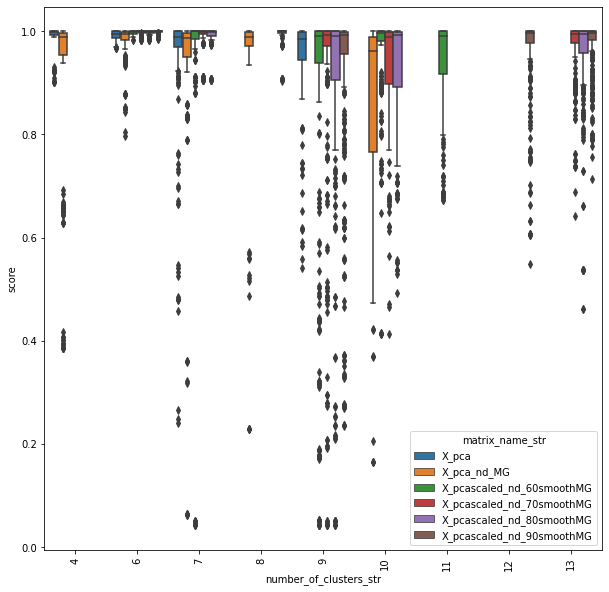

In [448]:
plot_robustness_byhue(leiden_bymatrix_numclust_pairwisescores_df, 'number_of_clusters', 'matrix_name')

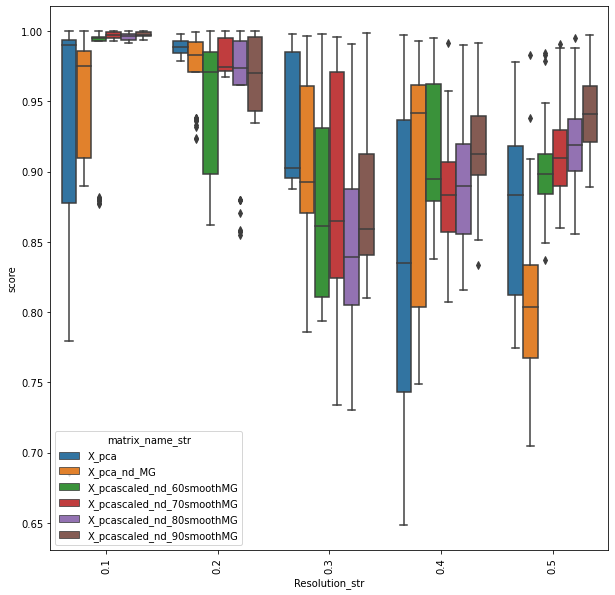

In [449]:
plot_robustness_byhue(leiden_bymatrix_fowlkesmallows_resolutionscore, 'Resolution', 'matrix_name')

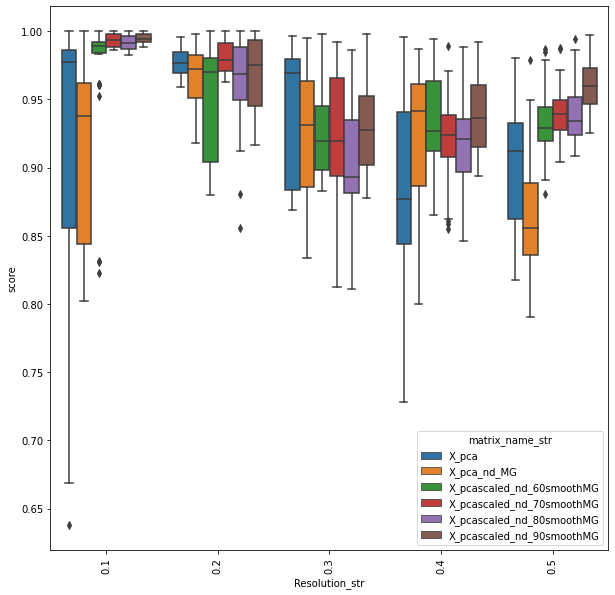

In [450]:
plot_robustness_byhue(leiden_bymatrix_homogeneity_resolutionscore, 'Resolution', 'matrix_name')

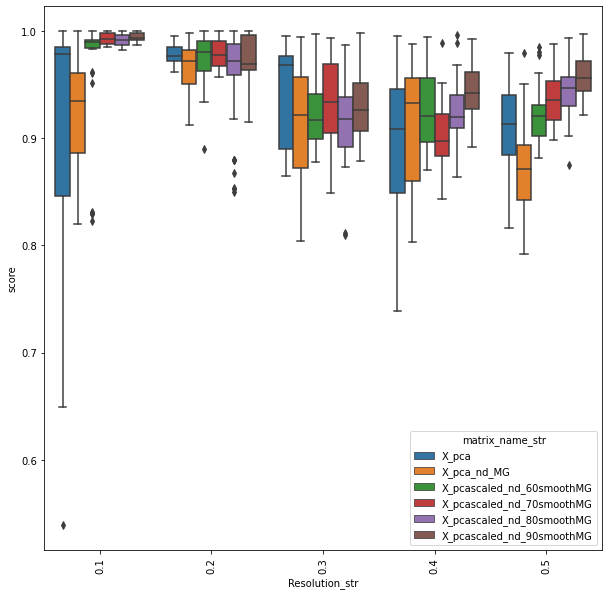

In [451]:
plot_robustness_byhue(leiden_bymatrix_completeness_resolutionscore, 'Resolution', 'matrix_name')

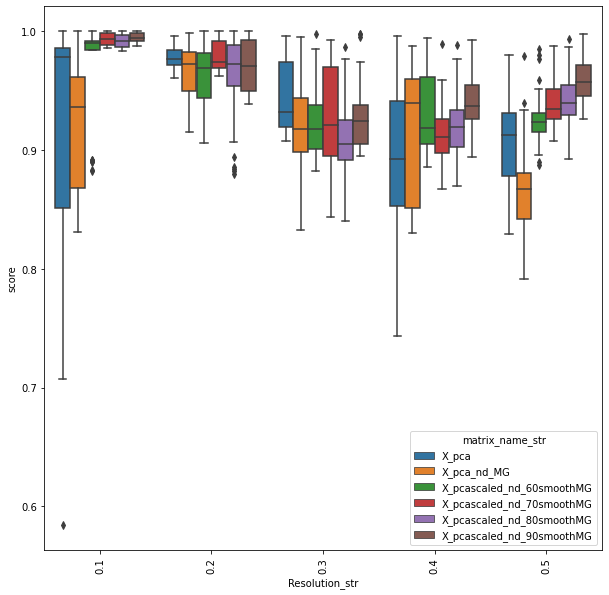

In [452]:
plot_robustness_byhue(leiden_bymatrix_vmeasure_resolutionscore, 'Resolution', 'matrix_name')

<H1> Agglomerative Clustering </H1>

<H2> Functions to score robustness for Agglomerative Clustering and how to add stocasticity</H2>

In [453]:
#Function for dataset split with the objective of adding stocasticity to Agglomerative Clustering
def train_test_split(seed, adata, X, train_frac=0.85):
    train_size = int(adata.shape[0] * train_frac)
    indices = np.arange(adata.shape[0])
    np.random.seed(seed)
    np.random.shuffle(indices)
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]
    mtx_connectivities = adata.obsp['connectivities'][train_idx, :][:, train_idx]
    mtx_train = X[train_idx, :]    
    return train_idx, mtx_connectivities, mtx_train

In [454]:
def get_aggclust_robustnessscore_fornumclust_bymatrix(ann_object, dataset_frac, matrix_dict, nclust_list):
    # Define a list of random values
    random_seeds = [i*10 for i in range(10)]
    # Initialize an empty dataframe for the temporal pairwise scores of the AggClustering
    pairwisescores_df = pd.DataFrame({}, columns=['number_of_clusters', 'matrix_name', 'score'])
    # Initialize an empty dataframe for the temporal Fowlkes Mallows Score of the AggClustering
    fowlkesmallowsscores_df = pd.DataFrame({}, columns=['number_of_clusters', 'matrix_name', 'score'])
    # Initialize an empty dataframe for the temporal Homogeneity Score of the AggClustering
    homogeneityscores_df = pd.DataFrame({}, columns=['number_of_clusters', 'matrix_name', 'score'])
    # Initialize an empty dataframe for the temporal Completness Score of the AggClustering
    completenessscores_df = pd.DataFrame({}, columns=['number_of_clusters', 'matrix_name', 'score'])
    # Initialize an empty dataframe for the temporal v_measure_score of the AggClustering
    vmeasurescores_df = pd.DataFrame({}, columns=['number_of_clusters', 'matrix_name', 'score'])
    
    # For each matrix type (PCA, PCA+MG, PCA + smoothedMG)
    for matrix_name, matrix in matrix_dict.items():
        # For each number of clusters
        for nclust in nclust_list:
            # Initialize an empy dataframe for the temporal results of AggClustering
            df_temporal = pd.DataFrame()
            # For each random value to define the seed to initialize the split of the dataset:
            for seed in random_seeds:
                # Random fraction of 85% of the dataset
                ann_object_agg_robust_temporal = ann_object.copy()
                train_idx, mtx_connectivities, mtx_train = train_test_split(seed, ann_object_agg_robust_temporal, matrix, dataset_frac)
                # Execute the AggClustering with the params of the loops
                agg = cluster.AgglomerativeClustering(n_clusters=nclust, connectivity=mtx_connectivities, linkage='ward', compute_distances=True).fit(mtx_train)
                # Input the ->cluster number<- results to the temporal dataframe for AggClustering results
                ann_object_agg_robust_temporal.obs.loc[ann_object_agg_robust_temporal[train_idx].obs_names,'Robust_AggCluster'] = agg.labels_.astype(str)
                ## PAIRWISE SCORE METHOD
                df_temporal[seed] = list(ann_object_agg_robust_temporal.obs['Robust_AggCluster'])
            # With all the results of the AggClustering using all the params on the loops -> get the robustness scores of the pairwise method
            pairwise_scores, no_data = get_robustnessscore_ofpairwisemethod(itertools.combinations(random_seeds,2), df_temporal)
            # Input the PAIRWISE METHOD SCORES to the temporal dataframe for pairwise scores of the AggClustering clustering
            for cl in pairwise_scores: pairwisescores_df = pd.concat([pairwisescores_df,pd.DataFrame({'number_of_clusters': [nclust], 'matrix_name': [matrix_name], 'score': [cl]})], ignore_index=True)
            '''
            # Input the GLOBAL SCORES to the temporal dataframe for specific global scores of the Leiden clustering
            for gl in fowlkes_mallows_score_list: fowlkesmallowsscores_df = pd.concat([fowlkesmallowsscores_df,pd.DataFrame({'number_of_clusters': [nclust], 'matrix_name': [matrix_name], 'score': [gl]})], ignore_index=True)
            for gl in homogeneity_score_list: homogeneityscores_df = pd.concat([homogeneityscores_df,pd.DataFrame({'number_of_clusters': [nclust], 'matrix_name': [matrix_name], 'score': [gl]})], ignore_index=True)
            for gl in completeness_score_list: completenessscores_df = pd.concat([completenessscores_df,pd.DataFrame({'number_of_clusters': [nclust], 'matrix_name': [matrix_name], 'score': [gl]})], ignore_index=True)
            for gl in v_measure_score_list: vmeasurescores_df = pd.concat([vmeasurescores_df,pd.DataFrame({'number_of_clusters': [nclust], 'matrix_name': [matrix_name], 'score': [gl]})], ignore_index=True)
            '''
    return pairwisescores_df, fowlkesmallowsscores_df, homogeneityscores_df, completenessscores_df, vmeasurescores_df

<H2> Demonstraiting deterministic Agglomerative Clustering algorithm </H2>

... storing 'AgglomerativeClustering' as categorical
... storing 'AgglomerativeClustering' as categorical
... storing 'AgglomerativeClustering' as categorical


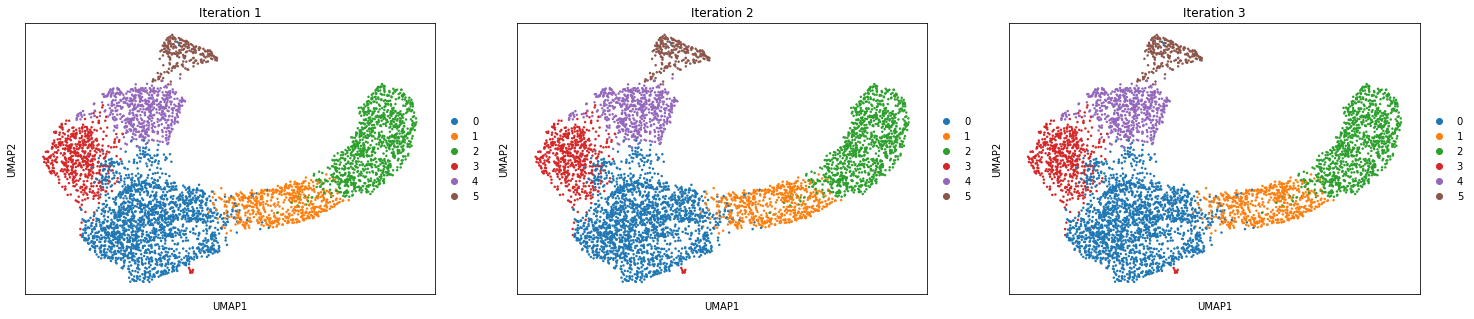

In [500]:
fig, axs = plt.subplots(1,3, figsize=(25,5))
for iteration in range(3):
    annobject_agg_demonstrate = annobject_agglomerative_clustering.copy()
    agg = cluster.AgglomerativeClustering(n_clusters=6, connectivity=annobject_agg_demonstrate.obsp['connectivities'], linkage='ward', compute_distances=True).fit(annobject_agg_demonstrate.obsm['X_pca'])
    annobject_agg_demonstrate.obs['AgglomerativeClustering'] = agg.labels_.astype(str)    
    sc.pl.umap(annobject_agg_demonstrate, color=['AgglomerativeClustering'], ax=axs[iteration], show=False)
    axs[iteration].set_title(f'Iteration {iteration+1}')
plt.show()

<H2> Adding stocasticity to Agglomerative Clustering algorithm </H2>

In [ ]:
for iteration in range(5):
    train_idx, mtx_connectivities, mtx_train = train_test_split(iteration*10, ann_object_agg, ann_object_agg.obsm['X_pca'], 0.85)
    agg = cluster.AgglomerativeClustering(n_clusters=6, connectivity=mtx_connectivities, linkage='ward', compute_distances=True).fit(mtx_train)
    ann_object_agg.obs.loc[ann_object_agg[train_idx].obs_names,f'AgglomerativeClustering_PCA85_NClust6_iteration{iteration}'] = agg.labels_.astype(str)
    sc.pl.umap(ann_object_agg, color=f'AgglomerativeClustering_PCA85_NClust6_iteration{iteration}')

... storing 'AgglomerativeClustering' as categorical
... storing 'AgglomerativeClustering' as categorical
... storing 'AgglomerativeClustering' as categorical


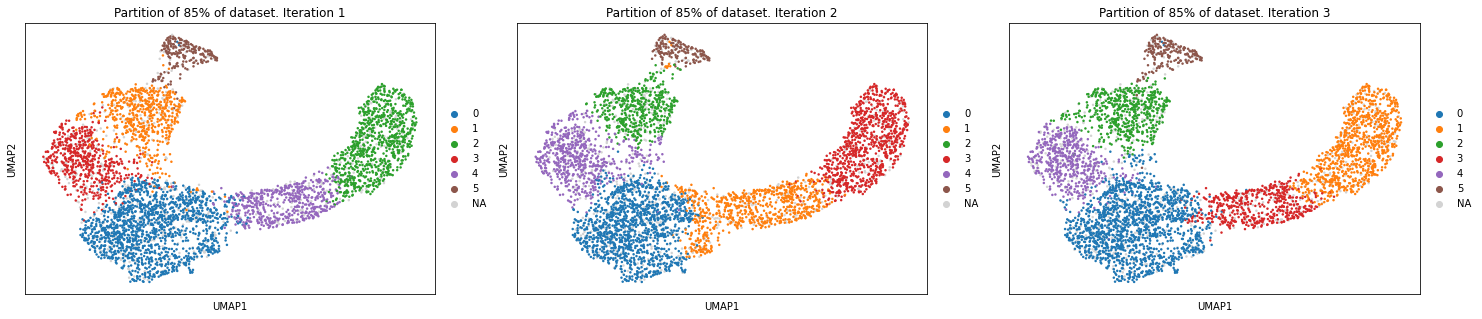

In [507]:
fig, axs = plt.subplots(1,3, figsize=(25,5))
for iteration in range(3):
    annobject_agg_demonstrate = annobject_agglomerative_clustering.copy()
    train_idx, mtx_connectivities, mtx_train = train_test_split(iteration*10, annobject_agg_demonstrate, annobject_agg_demonstrate.obsm['X_pca'], 0.85)
    agg = cluster.AgglomerativeClustering(n_clusters=6, connectivity=mtx_connectivities, linkage='ward', compute_distances=True).fit(mtx_train)
    annobject_agg_demonstrate.obs.loc[annobject_agg_demonstrate[train_idx].obs_names,'AgglomerativeClustering'] = agg.labels_.astype(str)
    sc.pl.umap(annobject_agg_demonstrate, color=['AgglomerativeClustering'], ax=axs[iteration], show=False)
    axs[iteration].set_title(f'Partition of 85% of dataset. Iteration {iteration+1}')
plt.show()

<H2> Checking Robustness of resolution by matrix (PCA, PCA+MG, PCA+smoothedMG)</H2>

In [455]:
annobject_agglomerative_clustering = ann_object_cleaned_feature_selected.copy()
aggclust_matrix_dict = {
                        'X_pca': annobject_agglomerative_clustering.obsm['X_pca'], 
                        'X_pca_nd_MG': concatenated_mtx, 
                        'X_pcascaled_nd_60smoothMG': concatenated_mtx_smoothed_60,
                        'X_pcascaled_nd_70smoothMG': concatenated_mtx_smoothed_70,
                        'X_pcascaled_nd_80smoothMG': concatenated_mtx_smoothed_80,
                        'X_pcascaled_nd_90smoothMG': concatenated_mtx_smoothed_90
                     }

In [456]:
aggclust_pairwisescores_metric_df, aggclust_fowlkesmallows_df, aggclust_homogeneity_df, aggclust_completeness_df, aggclust_vmeasurescores_df = get_aggclust_robustnessscore_fornumclust_bymatrix(annobject_agglomerative_clustering, 0.85, aggclust_matrix_dict, [4,5,6,7,8])

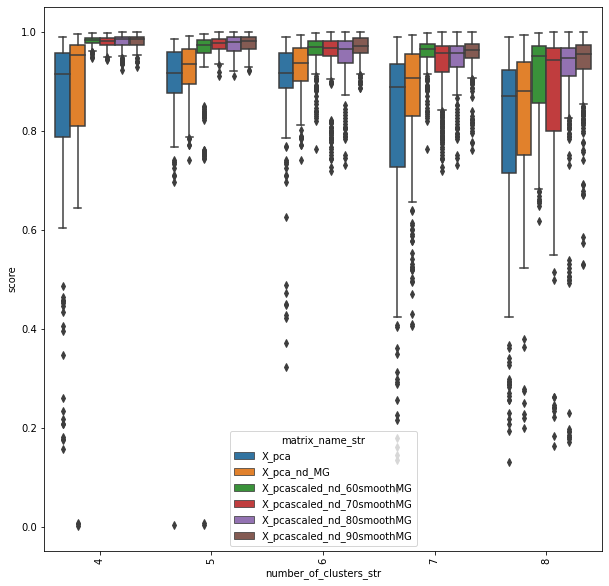

In [461]:
plot_robustness_byhue(aggclust_pairwisescores_metric_df, 'number_of_clusters', 'matrix_name')

<H2> Comparing Leiden and Agglomerative </H2>

In [463]:
def plot_compare_clusterings(Leiden_df, Leiden_metric_name, Leiden_hue_name, Agg_df, Agg_metric_name, Agg_hue_name):
    #LEIDEN
    Leiden_df = Leiden_df.sort_values(by=[Leiden_metric_name,Leiden_hue_name])
    if Leiden_df[Leiden_hue_name].dtype == float:
        Leiden_df[f'{Leiden_hue_name}_str'] = round(Leiden_df[Leiden_hue_name],2).astype(str)
    else:
        Leiden_df[f'{Leiden_hue_name}_str'] = Leiden_df[Leiden_hue_name].astype(str)
    if Leiden_df[Leiden_metric_name].dtype == float:
        Leiden_df[f'{Leiden_metric_name}_str'] = round(Leiden_df[Leiden_metric_name],1).astype(str)
    else:
        Leiden_df[f'{Leiden_metric_name}_str'] = Leiden_df[Leiden_metric_name].astype(str)
    Leiden_filtered_df = Leiden_df[Leiden_df['score']>0]
    #AGG
    Agg_df = Agg_df.sort_values(by=[Agg_metric_name,Agg_hue_name])
    if Agg_df[Agg_hue_name].dtype == float:
        Agg_df[f'{Agg_hue_name}_str'] = round(Agg_df[Agg_hue_name],2).astype(str)
    else:
        Agg_df[f'{Agg_hue_name}_str'] = Agg_df[Agg_hue_name].astype(str)
    if Agg_df[Agg_metric_name].dtype == float:
        Agg_df[f'{Agg_metric_name}_str'] = round(Agg_df[Agg_metric_name],1).astype(str)
    else:
        Agg_df[f'{Agg_metric_name}_str'] = Agg_df[Agg_metric_name].astype(str)            
    Agg_filtered_df = Agg_df[Agg_df['score']>0]
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))
    ax = sns.boxplot(data=Leiden_filtered_df, x=f'{Leiden_metric_name}_str', y='score', hue=f'{Leiden_hue_name}_str', ax=axs[0])
    axs[0].set_title('Leiden Algorithm')
    axs[0].set_xlabel = Leiden_metric_name
    axs[0].set_ylabel = 'Robustness Score'
    #locs, labels = plt.xticks(rotation='vertical')
    ax = sns.boxplot(data=Agg_filtered_df, x=f'{Agg_metric_name}_str', y='score', hue=f'{Agg_hue_name}_str', ax=axs[1])
    axs[1].set_title('Agglomerative Clustering Algorithm')
    axs[1].set_xlabel = Agg_metric_name
    axs[1].set_ylabel = 'Robustness Score'

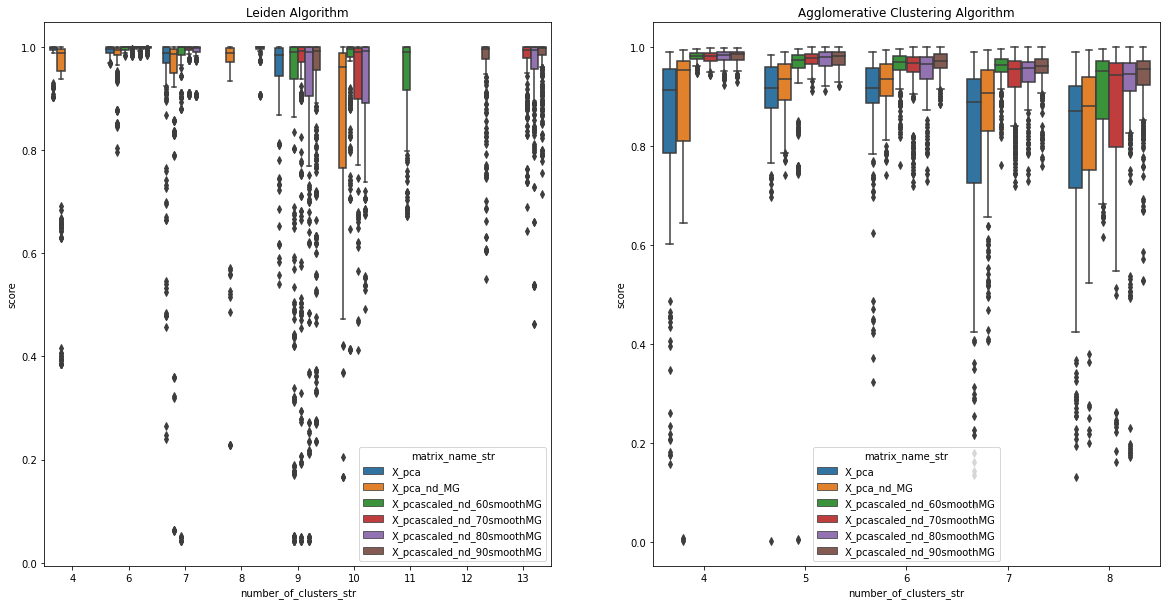

In [464]:
plot_compare_clusterings(leiden_bymatrix_numclust_pairwisescores_df, 'number_of_clusters', 'matrix_name',aggclust_pairwisescores_metric_df, 'number_of_clusters', 'matrix_name')